In [1]:
import pymc4 as pm
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
config = tf.ConfigProto()
config.graph_options.optimizer_options.global_jit_level = (
    tf.OptimizerOptions.ON_1)
config.intra_op_parallelism_threads = 1
config.inter_op_parallelism_threads = 1
sess = tf.InteractiveSession(config=config)

# Linear Regression

In [3]:
# Logp calculation for linear regression 
@pm.model
def linreg(sd_prior='half_normal', n_points = 100):    
    # Define priors
    sigma = pm.HalfNormal('sigma', scale = 10)
    intercept = pm.Normal('Intercept', 0, scale=10)
    x_coeff = pm.Normal('weight', 0, scale = 5)
    x = np.linspace(-5, 5, n_points)
    
    # Define likelihood
    y = pm.Normal('y', loc=intercept + x_coeff * x, scale=sigma)
    
    
model = linreg.configure()

forward_sample = sess.run(model.forward_sample())

forward_sample

{'sigma': 5.4259596,
 'Intercept': -19.606337,
 'weight': 0.88683015,
 'y': array([-27.669046 , -17.409462 , -19.50711  , -26.763836 , -35.389275 ,
        -24.28523  , -23.41587  , -11.84641  , -24.269382 , -27.037067 ,
        -15.957651 , -15.234988 , -22.83929  , -13.1659155, -29.071405 ,
        -44.062855 , -21.706211 , -16.516382 , -24.450031 , -27.92798  ,
        -25.726562 , -17.163452 , -19.93773  , -28.906307 , -24.181278 ,
        -24.30494  , -30.08627  , -19.768103 , -14.94397  , -29.438423 ,
        -30.446266 , -19.061699 , -21.101969 , -15.306091 , -19.220139 ,
        -11.044308 , -24.888615 , -27.494587 , -17.356228 , -24.940668 ,
        -23.00938  , -17.374477 ,  -6.4632473, -18.765148 , -29.674885 ,
        -15.516668 , -22.140575 , -19.773577 , -19.246725 , -23.603806 ,
        -27.878452 , -22.114254 , -22.417639 , -21.01201  , -32.012474 ,
        -14.785548 , -21.254183 , -10.701466 , -12.434264 , -18.677904 ,
         -9.471031 , -18.499367 , -19.517153 , -1

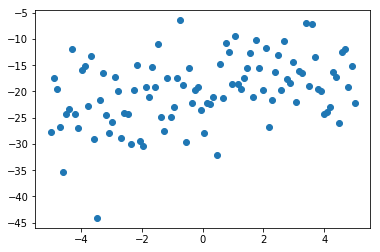

In [4]:
plt.scatter(np.linspace(-5, 5, 100), forward_sample['y'])

In [5]:
func = model.make_log_prob_function()
sigma = tf.placeholder(tf.float32)
intercept = tf.placeholder(tf.float32)
x_coeff = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32, shape=(100,))
logp = func(sigma, intercept, x_coeff, y)


In [6]:
feed_dict = {sigma: forward_sample['sigma'], 
            intercept: forward_sample['Intercept'], 
            x_coeff: forward_sample['weight'], 
            y: forward_sample['y']}

sess.run(logp, feed_dict=feed_dict)

-330.91013

In [7]:
import pymc3 as pm3

/anaconda3/envs/GSoC/lib/python3.6/subprocess.py:766: ResourceWarning: subprocess 3121 is still running
  ResourceWarning, source=self)
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/misc/cpucount.py:48: ResourceWarning: unclosed file <_io.TextIOWrapper name=59 encoding='UTF-8'>
  num = int(os.popen('sysctl -n hw.ncpu').read())
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/tests/main.py:6: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing.nosetester import NoseTester


In [8]:
n_points = 100
with pm3.Model() as model3: 
    # Define priors
    sigma = pm3.HalfNormal('sigma', sd = 10, observed=forward_sample['sigma'])
    intercept = pm3.Normal('Intercept', 0, 10, observed=forward_sample['Intercept'])
    x_coeff = pm3.Normal('weight', 0, 5, observed=forward_sample['weight'])
    x = np.linspace(-5, 5, n_points)
    
    # Define likelihood
    y = pm3.Normal('y', intercept + x_coeff * x, sigma, observed=forward_sample['y'])
    
model3.logp()

/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py

array(-330.91014434)

# Centered-Eight 

In [9]:
schools = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
sigma = tf.to_float(np.array([15., 10., 16., 11.,  9., 11., 10., 18.]))
n_points = 8

@pm.model
def centered_eight(n_points = n_points):    
    # Define priors
    mu = pm.Normal('mu', loc = 0, scale = 5)
    tau = pm.HalfCauchy('tau', loc = 0, scale = 5)
    theta = pm.Normal('theta', loc = tf.fill([8], mu.as_tensor()), scale = tf.fill([8], tau.as_tensor()))
    # Awkward syntax: Feature?
    
    # Define likelihood
    y = pm.Normal('y', loc = theta, scale = sigma)
    
model = centered_eight.configure()

forward_sample = sess.run(model.forward_sample())

forward_sample

{'mu': 0.6858591,
 'tau': 2.3695068,
 'theta': array([-5.3857846 , -1.3498095 ,  0.03760004,  4.108085  , -2.9670043 ,
        -1.5690862 , -1.3381232 ,  1.1491148 ], dtype=float32),
 'y': array([ 10.2343025 , -15.476729  ,  -8.506271  ,   0.61995983,
        -13.0782585 ,  -7.444225  , -10.934603  ,   8.229874  ],
       dtype=float32)}

In [10]:
func = model.make_log_prob_function()
mu = tf.placeholder(tf.float32)
tau = tf.placeholder(tf.float32)
theta = tf.placeholder(tf.float32, shape=(n_points,))
y = tf.placeholder(tf.float32, shape=(n_points,))
logp = func(mu, tau, theta, y)

In [11]:
feed_dict = {mu: forward_sample['mu'], 
            tau: forward_sample['tau'], 
            theta: forward_sample['theta'], 
            y: schools}

sess.run(logp, feed_dict=feed_dict)

-58.20176

In [12]:
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])
with pm3.Model() as model3: 
    # Define priors
    mu = pm3.Normal('mu', 0, sd = 5, observed=forward_sample['mu'])
    tau = pm3.HalfCauchy('Intercept', 5, observed=forward_sample['tau'])
    theta = pm3.Normal('weight', mu, tau, observed=forward_sample['theta'])
    
    # Define likelihood
    y = pm3.Normal('y', theta, sigma, observed=schools)
    
model3.logp()

/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py

array(-58.20175703)